In [ ]:
import pathlib

import numpy as np
from IPython.display import Code

import ratapi as RAT
from ratapi.models import Parameter

# Custom XY Example for Supported DSPC layer.

In this example, we model the same data (DSPC supported bilayer) as the Custom Layers example, but this time we will use continuous distributions of the volume fractions of each component to build up the SLD profiles (as described in Shekhar et al, *J. Appl. Phys.*, **110**, 102216 (2011).)

In this type of model, each 'layer' in the sample is described by a roughened Heaviside step function (really, just two error functions back to back). So, in our case, we will need an oxide, a (possible) intervening water layer, and then the bilayer itself.

We can define our lipid in terms of an Area per Molecule, almost in it's entirity, if we recognise that where the volume is known, the thickness of the layer is simply given by the layer volume / APM
$$
d = \frac{V}{APM}.
$$
We can then define the Volume Fraction of this layer with a roughened Heaviside of length dlayer and a height of 1. Then, the total volume occupied will be given by the sum of the volume fractions across the interface. Of course, this does not permit any hydration, so to deal with this, we can simply scale the (full occupation) Heaviside functions by relevant coverage parameters. When this is correctly done, we can obtain the remaining water distribution as
$$
VF_{water} =  1 - \sum_{n}VF_{n},
$$
where $VF_{n}$ is the Volume Fraction of the n'th layer.
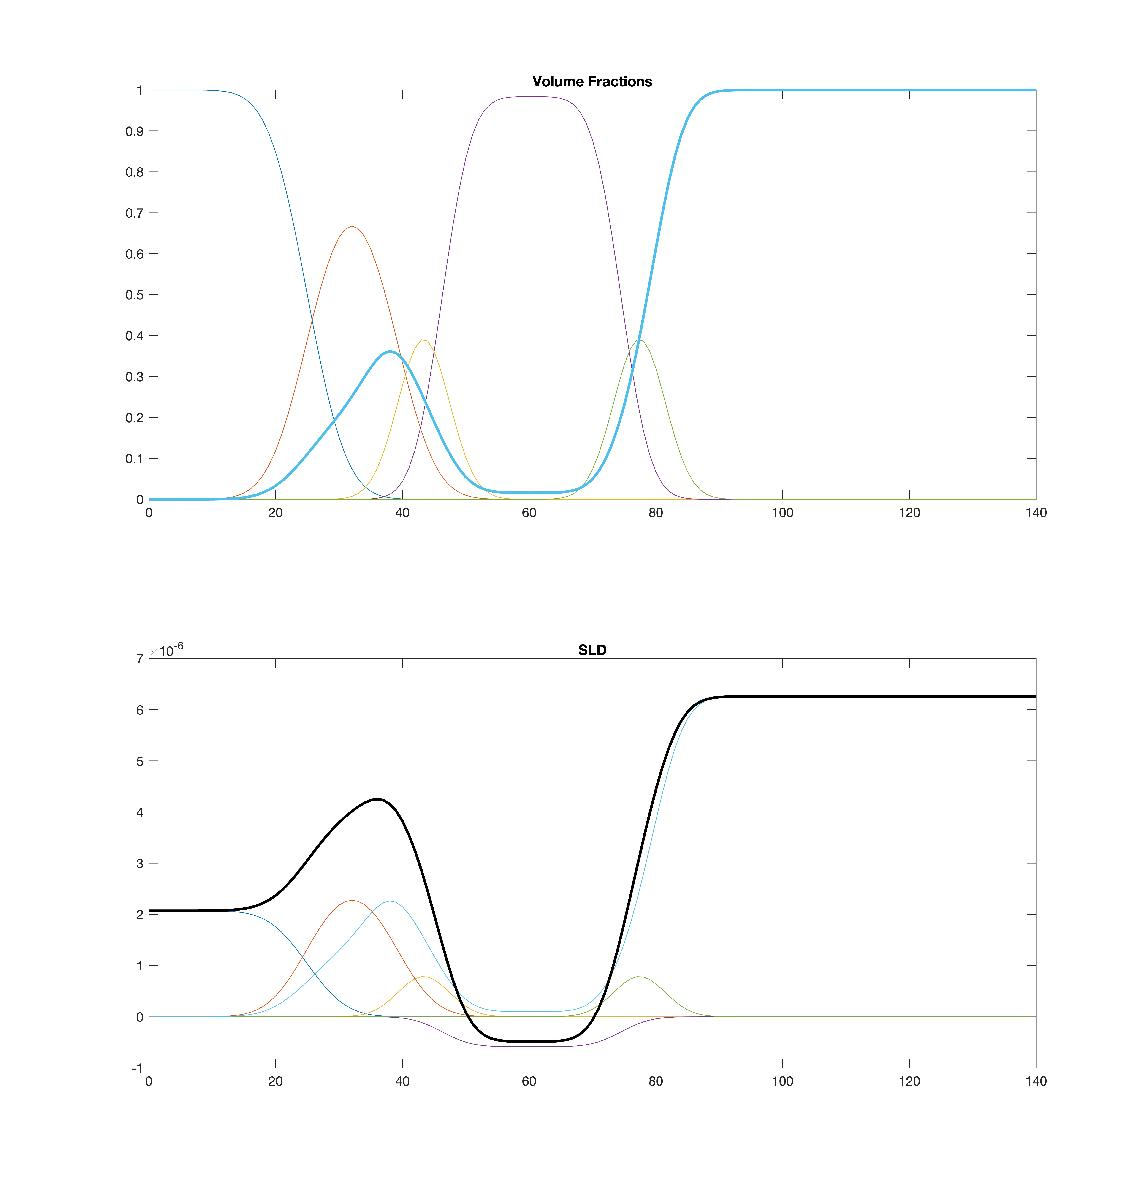
Start by making the class and setting it to a custom XY type:

In [ ]:
problem = RAT.Project(name="Orso lipid example - custom XY", model="custom xy", geometry="substrate/liquid")

We need to add the relevant parameters we are going to need to define the model (note that Substrate Roughness always exists as parameter 0)

In [ ]:
parameter_list = [
    Parameter(name="Oxide Thickness", min=10.0, value=15.0, max=30.0, fit=True),
    Parameter(name="Oxide Hydration", min=0.1, value=0.2, max=0.4, fit=True),
    Parameter(name="Water Thickness", min=0.0, value=5.0, max=20.0, fit=True),
    Parameter(name="Lipid APM", min=40.0, value=50.0, max=90.0, fit=True),
    Parameter(name="Lipid Coverage", min=0.9, value=1.0, max=1.0, fit=True),
    Parameter(name="Bilayer Roughness", min=3.0, value=5.0, max=8.0, fit=True)
]

problem.parameters.extend(parameter_list)

problem.parameters.set_fields(0, min=1.0, max=10.0)

Need to add the relevant Bulk SLDs. Change the bulk in from air to silicon, and add two additional water contrasts:

In [ ]:
# Change the bulk in from air to silicon
problem.bulk_in.set_fields(0, name="Silicon", min=2.07e-6, value=2.073e-6, max=2.08e-6, fit=False)

problem.bulk_out.append(name="SLD SMW", min=1.0e-6, value=2.073e-6, max=3.0e-6, fit=True)
problem.bulk_out.append(name="SLD H2O", min=-0.6e-6, value=-0.56e-6, max=-0.3e-6, fit=True)

problem.bulk_out.set_fields(0, min=5.0e-6, value=6.1e-6, fit=True)

Now add our datafiles:

In [ ]:
# Read in the datafiles
data_path = pathlib.Path("../data")
D2O_data = np.loadtxt(data_path / "c_PLP0016596.dat", delimiter=",")
SMW_data = np.loadtxt(data_path / "c_PLP0016601.dat", delimiter=",")
H2O_data = np.loadtxt(data_path / "c_PLP0016607.dat", delimiter=",")

# Add the data to the project - note this data has a resolution 4th column
problem.data.append(name="Bilayer / D2O", data=D2O_data)
problem.data.append(name="Bilayer / SMW", data=SMW_data)
problem.data.append(name="Bilayer / H2O", data=H2O_data)

Add the custom file to the project. We can view the code first.

In [ ]:
Code("custom_XY_DSPC.py")
problem.custom_files.append(name="DSPC Model", filename="custom_XY_DSPC.py", language="python", path=pathlib.Path.cwd().resolve())

Add and modify the remaining parameters - backgrounds, scalefactors, and resolutions:

In [ ]:
problem.background_parameters.set_fields(0, name="Background parameter D2O", fit=True, min=1.0e-10, max=1.0e-5, value=1.0e-07)

problem.background_parameters.append(name="Background parameter SMW", min=0.0, value=1.0e-7, max=1.0e-5, fit=True)
problem.background_parameters.append(name="Background parameter H2O", min=0.0, value=1.0e-7, max=1.0e-5, fit=True)

# And add the two new constant backgrounds
problem.backgrounds.append(name="Background SMW", type="constant", source="Background parameter SMW")
problem.backgrounds.append(name="Background H2O", type="constant", source="Background parameter H2O")

# And edit the other one
problem.backgrounds.set_fields(0, name="Background D2O", source="Background parameter D2O")

# Finally modify some of the other parameters to be more suitable values for a solid / liquid experiment
problem.scalefactors.set_fields(0, value=1.0, min=0.5, max=2.0, fit=True)

# Also, we are going to use the data resolution
problem.resolutions.append(name="Data Resolution", type="data")

Now add the three contrasts as before:

In [ ]:
problem.contrasts.append(
    name="Bilayer / D2O",
    background="Background D2O",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD D2O",
    bulk_in="Silicon",
    data="Bilayer / D2O",
    model=["DSPC Model"],
)

problem.contrasts.append(
    name="Bilayer / SMW",
    background="Background SMW",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD SMW",
    bulk_in="Silicon",
    data="Bilayer / SMW",
    model=["DSPC Model"],
)

problem.contrasts.append(
    name="Bilayer / H2O",
    background="Background H2O",
    resolution="Data Resolution",
    scalefactor="Scalefactor 1",
    bulk_out="SLD H2O",
    bulk_in="Silicon",
    data="Bilayer / H2O",
    model=["DSPC Model"],
)

## Running the Model

We do this by first making a controls block as previously. We'll run a Differential Evolution:

In [ ]:
controls = RAT.Controls(procedure="de", parallel="contrasts", display="final")
problem, results = RAT.run(problem, controls)
RAT.plotting.plot_ref_sld(problem, results)